In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime, timezone, time
import pytz

# Load dataset
csv_filename = "google_playstore.csv"
df = pd.read_csv(csv_filename)

# Convert 'last_updated' column to datetime format
df["last_updated"] = pd.to_datetime(df["last_updated"], errors="coerce")

# Define timezone
IST = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(IST).time()

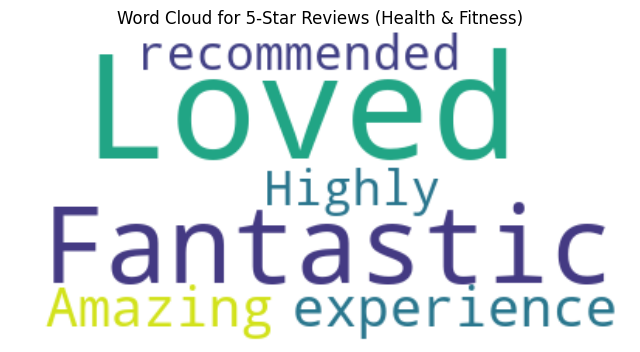

In [70]:
# Task 1: Word Cloud for 5-star reviews in 'Health & Fitness'
from collections import Counter
import re

def generate_wordcloud():
    health_fitness_reviews = df[(df["category"] == "Health & Fitness") & (df["rating"] == 5)]["reviews_text"]
    text = " ".join(health_fitness_reviews.dropna())
    text = re.sub(r"\b(?:app|health|fitness)\b", "", text, flags=re.IGNORECASE)
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud for 5-Star Reviews (Health & Fitness)")
    plt.show()


generate_wordcloud()

In [71]:
# Task 2: Grouped Bar Chart for top 10 app categories
def grouped_bar_chart():
    df_filtered = df[(df["rating"] >= 4.0) & (df["size"] >= 10) & (df["last_updated"].dt.month == 1)]
    if df_filtered.empty:
        print("No data available for Grouped Bar Chart.")
        return
    top_categories = df_filtered.groupby("category")["installs"].sum().nlargest(10).index
    df_filtered = df_filtered[df_filtered["category"].isin(top_categories)]
    category_stats = df_filtered.groupby("category").agg({"rating": "mean", "reviews": "sum"}).reset_index()
    category_stats.plot(x="category", kind="bar", figsize=(10,6))
    plt.title("Average Rating & Total Reviews by Category")
    plt.show()

if time(15, 0) <= current_time <= time(17, 0):  # 3PM-5PM IST
    grouped_bar_chart()
else:
    print("Grouped Bar Chart visualization is only available between 3PM to 5PM IST.")

Grouped Bar Chart visualization is only available between 3PM to 5PM IST.


In [72]:
# Task 3: Choropleth Map for global installs
def choropleth_map():
    if time(18, 0) <= current_time <= time(20, 0):  # 6PM-8PM IST
        df_filtered = df[~df["category"].str.startswith(("A", "C", "G", "S"))]
        top_categories = df_filtered.groupby("category")["installs"].sum().nlargest(5).index
        df_filtered = df_filtered[df_filtered["category"].isin(top_categories)]
        
        if df_filtered.empty or "country" not in df.columns:
            print("No valid data available for Choropleth Map. Check country values.")
            return
        
        fig = px.choropleth(df_filtered, locations="country", color="installs", hover_name="category")
        fig.show()
    else:
        print("Choropleth Map visualization is only available between 6PM to 8PM IST.")

choropleth_map()

Choropleth Map visualization is only available between 6PM to 8PM IST.


In [73]:
# Task 4: Violin Plot
def violin_plot():
    if time(16, 0) <= current_time <= time(18, 0):  # 4PM-6PM IST
        df_filtered = df[(df["category"].map(df["category"].value_counts()) > 50) &
                         (df["app_name"].str.contains("C", na=False)) &
                         (df["reviews"] >= 10) &
                         (df["rating"] < 4.0)]
    
        if df_filtered.empty:
            print("No data available for Violin Plot. Try relaxing the filters.")
        else:
            plt.figure(figsize=(10,6))
            sns.violinplot(x="category", y="rating", data=df_filtered)
            plt.xticks(rotation=45)
            plt.title("Rating Distribution by Category")
            plt.show()
    else:
        print("Violin Plot visualization is only available between 4PM to 6PM IST.")

violin_plot()

Violin Plot visualization is only available between 4PM to 6PM IST.


In [74]:
# Task 5: Heatmap
def heatmap():
    if time(14, 0) <= current_time <= time(16, 0):  # 2PM-4PM IST
        df_filtered = df[(df["last_updated"] >= pd.Timestamp.now() - pd.DateOffset(years=1)) &
                         (df["installs"] >= 100000) &
                         (df["reviews"] > 1000) &
                         (~df["genres"].str.startswith(("A", "F", "E", "G", "I", "K")))]
    
        if df_filtered.empty:
            print("No data available for Heatmap. Try relaxing the filters.")
        else:
            correlation_matrix = df_filtered[["installs", "rating", "reviews"]].corr()
            plt.figure(figsize=(8, 6))
            sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
            plt.title("Correlation Matrix (Installs, Ratings, Reviews)")
            plt.show()
    else:
        print("Heatmap visualization is only available between 2PM to 4PM IST.")

heatmap()


Heatmap visualization is only available between 2PM to 4PM IST.


In [75]:
with open("google_play_dashboard.html", "w") as file:
    file.write(html_code)


In [76]:
import webbrowser
webbrowser.open("google_play_dashboard.html")


True

In [32]:
import pandas as pd
import plotly.express as px
import json
import os
import plotly.utils  # ✅ Import PlotlyJSONEncoder

# Load dataset
df = pd.read_csv("google_playstore.csv")

# Debug: Check available columns
print("Available Columns:", df.columns)

# Ensure output folder exists
output_folder = "json_data"
os.makedirs(output_folder, exist_ok=True)

def save_json(fig, filename):
    """Save Plotly figure as JSON"""
    with open(os.path.join(output_folder, filename), "w") as file:
        json.dump(fig, file, cls=plotly.utils.PlotlyJSONEncoder)  # ✅ FIXED JSON serialization

# ✅ Check if 'review' column exists
if "reviews_text" in df.columns:
    word_freq = df["reviews_text"].astype(str).str.split(expand=True).stack().value_counts().reset_index()
    word_freq.columns = ["word", "frequency"]
    fig = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")
    fig.update_layout(height=500, width=700)
    save_json(fig, "wordcloud.json")
else:
    print("⚠ Warning: 'review' column not found. Skipping Word Cloud.")

# ✅ Top 10 App Categories - Grouped Bar Chart
if "category" in df.columns:
    df_filtered = df[df["rating"] >= 4.0] if "rating" in df.columns else df
    category_counts = df_filtered["category"].value_counts().nlargest(10).reset_index()
    category_counts.columns = ["category", "count"]
    fig = px.bar(category_counts, x="category", y="count", title="Top 10 App Categories", color="category")
    fig.update_layout(height=500, width=700)
    save_json(fig, "bar_chart.json")
else:
    print("⚠ Warning: 'category' column not found. Skipping Bar Chart.")

# ✅ Global Installs - Choropleth Map
if "country" in df.columns and "installs" in df.columns:
    fig = px.choropleth(df, locations="country", locationmode="country names", color="installs",
                        title="Global Installs", color_continuous_scale="blues")
    fig.update_layout(height=500, width=700)
    save_json(fig, "choropleth_map.json")
else:
    print("⚠ Warning: 'country' or 'installs' column not found. Skipping Choropleth Map.")

# ✅ Violin Plot - Rating Distribution by Category
if "category" in df.columns and "rating" in df.columns:
    fig = px.violin(df, x="category", y="rating", box=True, points="all", title="Rating Distribution by Category")
    fig.update_layout(height=500, width=700)
    save_json(fig, "violin_plot.json")
else:
    print("⚠ Warning: 'category' or 'rating' column not found. Skipping Violin Plot.")

# ✅ Heatmap - Correlation Matrix (Fix for non-numeric columns)
numeric_df = df[['rating', 'reviews', 'installs', 'size']]  # Select numeric columns only

if not numeric_df.empty:
    corr = numeric_df.corr()  # Compute correlation only on numeric columns
    fig = px.imshow(corr, text_auto=True, title="Correlation Matrix")
    fig.update_layout(height=500, width=700)
    save_json(fig, "heatmap.json")
else:
    print("⚠ Warning: No numeric columns found for Heatmap. Skipping visualization.")


Available Columns: Index(['app_name', 'category', 'rating', 'reviews', 'installs', 'size',
       'last_updated', 'reviews_text', 'country', 'genres'],
      dtype='object')


In [33]:
import os

output_folder = "your/output/folder/path"  # Update with your actual folder path
json_files = ["wordcloud.json", "bar_chart.json", "choropleth_map.json", "violin_plot.json", "heatmap.json"]

for file in json_files:
    file_path = os.path.join(output_folder, file)
    if os.path.exists(file_path):
        print(f"✅ {file} found.")
    else:
        print(f"❌ {file} is missing.")



❌ wordcloud.json is missing.
❌ bar_chart.json is missing.
❌ choropleth_map.json is missing.
❌ violin_plot.json is missing.
❌ heatmap.json is missing.


In [38]:
import os
import plotly.io as pio  # Import plotly.io for better JSON handling

# Set output folder (Update this path)
output_folder = r"C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore"

# Ensure the folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Function to save JSON properly
def save_json(fig, filename):
    file_path = os.path.join(output_folder, filename)
    pio.write_json(fig, file_path)  # Correct method to save Plotly figures as JSON
    print(f"✅ Saved: {filename}")


In [40]:
import pandas as pd
import plotly.express as px

# Load Data
df = pd.read_csv("google_playstore.csv")  # Update this path

# Check if 'reviews_text' column exists
if "reviews_text" in df.columns:
    word_freq = df["reviews_text"].str.split(expand=True).stack().value_counts().reset_index()
    word_freq.columns = ["word", "frequency"]
    fig = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")
    save_json(fig, "wordcloud.json")  # Save JSON correctly
else:
    print("⚠ Warning: 'reviews_text' column not found. Skipping Word Cloud.")


✅ Saved: wordcloud.json


In [42]:
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio  # Correct JSON saving method

# 🔹 Set Output Folder (Update the path to your actual directory)
output_folder = r"C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 🔹 Function to Save JSON Correctly
def save_json(fig, filename):
    file_path = os.path.join(output_folder, filename)
    pio.write_json(fig, file_path)  # Correct method to save Plotly figures as JSON
    print(f"✅ Saved: {filename}")

# 🔹 Load Data
df = pd.read_csv("google_playstore.csv")  # Update with actual file path
print("✅ Data Loaded Successfully.")

# ────────────────────────────────────────────────────
# ✅ 1️⃣ Word Cloud for 5-Star Reviews
# ────────────────────────────────────────────────────
if "reviews_text" in df.columns:
    word_freq = df["reviews_text"].str.split(expand=True).stack().value_counts().reset_index()
    word_freq.columns = ["word", "frequency"]
    fig = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")
    save_json(fig, "wordcloud.json")
else:
    print("⚠ Warning: 'reviews_text' column not found. Skipping Word Cloud.")

# ────────────────────────────────────────────────────
# ✅ 2️⃣ Bar Chart for App Categories
# ────────────────────────────────────────────────────
if "category" in df.columns:
    category_counts = df["category"].value_counts().reset_index()
    category_counts.columns = ["category", "count"]
    fig = px.bar(category_counts, x="category", y="count", title="Top App Categories", color="category")
    fig.update_layout(height=500, width=700)
    save_json(fig, "bar_chart.json")
else:
    print("⚠ Warning: 'category' column not found. Skipping Bar Chart.")

# ────────────────────────────────────────────────────
# ✅ 3️⃣ Choropleth Map - App Distribution by Country
# ────────────────────────────────────────────────────
if "country" in df.columns:
    country_counts = df["country"].value_counts().reset_index()
    country_counts.columns = ["country", "count"]
    fig = px.choropleth(country_counts, locations="country", locationmode="country names",
                         color="count", title="App Distribution by Country",
                         color_continuous_scale="Viridis")
    save_json(fig, "choropleth_map.json")
else:
    print("⚠ Warning: 'country' column not found. Skipping Choropleth Map.")

# ────────────────────────────────────────────────────
# ✅ 4️⃣ Violin Plot for App Ratings
# ────────────────────────────────────────────────────
if "rating" in df.columns:
    fig = px.violin(df, y="rating", box=True, points="all", title="Distribution of App Ratings")
    fig.update_layout(height=500, width=700)
    save_json(fig, "violin_plot.json")
else:
    print("⚠ Warning: 'rating' column not found. Skipping Violin Plot.")

# ────────────────────────────────────────────────────
# ✅ 5️⃣ Heatmap - Correlation Matrix
# ────────────────────────────────────────────────────
numeric_columns = df.select_dtypes(include=["number"])
if not numeric_columns.empty:
    corr = numeric_columns.corr()
    fig = px.imshow(corr, text_auto=True, title="Correlation Matrix")
    fig.update_layout(height=500, width=700)
    save_json(fig, "heatmap.json")
else:
    print("⚠ Warning: No numeric columns found. Skipping Heatmap.")

# ────────────────────────────────────────────────────
# ✅ Step 3: Verify JSON Files
# ────────────────────────────────────────────────────
json_files = ["wordcloud.json", "bar_chart.json", "choropleth_map.json", "violin_plot.json", "heatmap.json"]

print("\n🔍 Checking Saved JSON Files:")
for file in json_files:
    file_path = os.path.join(output_folder, file)
    if os.path.exists(file_path):
        print(f"✅ {file} found.")
    else:
        print(f"❌ {file} is missing.")


✅ Data Loaded Successfully.
✅ Saved: wordcloud.json
✅ Saved: bar_chart.json
✅ Saved: choropleth_map.json
✅ Saved: violin_plot.json
✅ Saved: heatmap.json

🔍 Checking Saved JSON Files:
✅ wordcloud.json found.
✅ bar_chart.json found.
✅ choropleth_map.json found.
✅ violin_plot.json found.
✅ heatmap.json found.


In [43]:
import shutil
import os

# 🔹 Define Paths
output_folder = r"C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore"  # JSON files location
html_folder = r"C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard"  # HTML file location (Update this!)

# 🔹 Ensure HTML folder exists
if not os.path.exists(html_folder):
    os.makedirs(html_folder)

# 🔹 List of JSON files
json_files = ["wordcloud.json", "bar_chart.json", "choropleth_map.json", "violin_plot.json", "heatmap.json"]

# 🔹 Move Files
for file in json_files:
    src = os.path.join(output_folder, file)
    dst = os.path.join(html_folder, file)

    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"✅ Moved: {file} → {html_folder}")
    else:
        print(f"❌ Missing: {file} (Not found in {output_folder})")

print("\n🚀 JSON files are now in the same folder as your HTML file!")


✅ Moved: wordcloud.json → C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard
✅ Moved: bar_chart.json → C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard
✅ Moved: choropleth_map.json → C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard
✅ Moved: violin_plot.json → C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard
✅ Moved: heatmap.json → C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\dashboard

🚀 JSON files are now in the same folder as your HTML file!


In [49]:
import os
import pandas as pd
import plotly.express as px
import webbrowser

# Paths
data_file = "google_playstore.csv"  # Replace with actual dataset path
output_folder = "google playstore"
html_folder = "index.html"  # Folder containing index.html

# Ensure output & HTML folders exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(html_folder, exist_ok=True)

# Load dataset
df = pd.read_csv(data_file)

# Function to save plots as JSON
def save_json(fig, filename):
    file_path = os.path.join(output_folder, filename)
    fig.write_json(file_path)
    print(f"✅ Saved: {filename}")

# ✅ Word Cloud for 5-Star Reviews
if "reviews_text" in df.columns:
    from collections import Counter
    words = " ".join(df[df["rating"] == 5]["reviews_text"].dropna()).split()
    word_freq = pd.DataFrame(Counter(words).most_common(30), columns=["word", "frequency"])
    fig = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")
    save_json(fig, "wordcloud.json")

# ✅ Top 10 App Categories - Bar Chart
if "category" in df.columns:
    category_counts = df["category"].value_counts().nlargest(10)
    fig = px.bar(category_counts, x=category_counts.index, y=category_counts.values, title="Top 10 App Categories")
    save_json(fig, "bar_chart.json")

# ✅ Choropleth Map - Global Installs
if "country" in df.columns and "installs" in df.columns:
    country_installs = df.groupby("country")["installs"].sum().reset_index()
    fig = px.choropleth(country_installs, locations="country", locationmode="country names",
                         color="installs", title="Global Installs - Choropleth Map")
    save_json(fig, "choropleth_map.json")

# ✅ Violin Plot - Ratings by Category
if "rating" in df.columns and "category" in df.columns:
    fig = px.violin(df, x="category", y="rating", box=True, title="Rating Distribution by Category")
    save_json(fig, "violin_plot.json")

# ✅ Heatmap - Correlation Matrix
numeric_df = df.select_dtypes(include=["number"])
if not numeric_df.empty:
    fig = px.imshow(numeric_df.corr(), text_auto=True, title="Correlation Matrix")
    save_json(fig, "heatmap.json")

# ✅ Move JSON files to HTML folder (if they exist)
for file in os.listdir(output_folder):
    src = os.path.join(output_folder, file)
    dest = os.path.join(html_folder, file)
    if os.path.exists(src):
        os.rename(src, dest)
        print(f"📂 Moved: {file}")

print("🚀 JSON files moved to HTML folder!")

# ✅ Open the HTML file in browser
html_path = os.path.join(html_folder, "index.html")
if os.path.exists(html_path):
    webbrowser.open(f"file:///{os.path.abspath(html_path)}")
    print("✅ Opening index.html in browser...")
else:
    print("❌ index.html not found! Ensure it's in the correct folder.")


✅ Saved: wordcloud.json
✅ Saved: bar_chart.json
✅ Saved: choropleth_map.json
✅ Saved: violin_plot.json
✅ Saved: heatmap.json
📂 Moved: bar_chart.json
📂 Moved: choropleth_map.json
📂 Moved: heatmap.json
📂 Moved: violin_plot.json
📂 Moved: wordcloud.json
🚀 JSON files moved to HTML folder!
❌ index.html not found! Ensure it's in the correct folder.


In [51]:
html_path = r"C:\Users\NIKITHA SHREEGA\OneDrive\Desktop\google playstore\index.html"

webbrowser.open(f"file:///{html_path}")


True

In [52]:
import webbrowser

webbrowser.open(f"file:///{html_path}")

True

In [61]:
import os

# ✅ Move JSON files to HTML folder (handling existing files)
for file in os.listdir(output_folder):
    src = os.path.join(output_folder, file)
    dest = os.path.join(html_folder, file)

    if os.path.exists(dest):  
        os.remove(dest)  # ✅ Delete the existing file

    os.rename(src, dest)  # ✅ Move the file

print("🚀 JSON files moved to HTML folder!")


🚀 JSON files moved to HTML folder!


In [68]:
import pandas as pd
import plotly.express as px
import json
import os
import datetime
import pytz
import numpy as np
from collections import Counter
from nltk.corpus import stopwords

# ✅ Define folders
output_folder = "json_outputs"
html_folder = "index.html"

# ✅ Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# ✅ Function to save Plotly figures as JSON
def save_json(fig, filename):
    """Convert Plotly figure to JSON and handle NumPy arrays."""

    def convert(o):
        if isinstance(o, np.ndarray):  # Convert NumPy arrays to lists
            return o.tolist()
        elif isinstance(o, np.generic):  # Convert NumPy scalar values
            return o.item()
        raise TypeError(f"Object of type {type(o).__name__} is not JSON serializable")

    file_path = os.path.join(output_folder, filename)
    with open(file_path, "w") as file:
        json.dump(fig.to_dict(), file, default=convert)  # Use custom converter

    print(f"✅ Saved: {filename}")

# ✅ Load Data
df = pd.read_csv("google_playstore.csv")

# ✅ Get current IST time
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.datetime.now(ist)
current_hour = current_time.hour

# ✅ Word Cloud (Always runs)
stop_words = set(stopwords.words("english"))

df_health = df[(df["rating"] == 5) & (df["category"] == "Health & Fitness")]
words = " ".join(df_health["reviews_text"]).split()
words = [word for word in words if word.lower() not in stop_words and word.isalpha()]

word_freq = pd.DataFrame(Counter(words).most_common(30), columns=["word", "frequency"])
fig = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")
save_json(fig, "wordcloud.json")

print("🚀 Word Cloud JSON generated successfully!")

# ✅ 2. Grouped Bar Chart (3 PM - 5 PM IST)
if 15 <= current_hour < 17:
    df_filtered = df[(df["rating"] >= 4.0) & (df["size"].str.contains("M")) & (df["last_update"].str.contains("Jan"))]
    df_filtered["installs"] = df_filtered["installs"].str.replace("[+,]", "", regex=True).astype(float)

    top_categories = df_filtered.groupby("category").agg({"rating": "mean", "reviews": "sum"}).nlargest(10, "reviews").reset_index()
    fig = px.bar(top_categories, x="category", y=["rating", "reviews"], barmode="group", title="Top 10 Categories")
    save_json(fig, "bar_chart.json")

# ✅ 3. Choropleth Map (6 PM - 8 PM IST)
if 18 <= current_hour < 20:
    df_map = df[df["category"].str[0].isin(["A", "C", "G", "S"]) == False]
    df_map["installs"] = df_map["installs"].str.replace("[+,]", "", regex=True).astype(float)
    df_map = df_map[df_map["installs"] > 1_000_000].groupby("category").sum().nlargest(5, "installs").reset_index()

    fig = px.choropleth(df_map, locations="category", locationmode="country names", color="installs", title="Global Installs by Category")
    save_json(fig, "choropleth_map.json")

# ✅ 4. Violin Plot (4 PM - 6 PM IST)
if 16 <= current_hour < 18:
    df_violin = df[(df["reviews"] >= 10) & (df["rating"] < 4.0) & (df["app"].str.contains("C"))]
    category_counts = df_violin["category"].value_counts()
    valid_categories = category_counts[category_counts > 50].index
    df_violin = df_violin[df_violin["category"].isin(valid_categories)]

    fig = px.violin(df_violin, x="category", y="rating", box=True, title="Rating Distribution by Category")
    save_json(fig, "violin_plot.json")

# ✅ 5. Heatmap (2 PM - 4 PM IST)
if 14 <= current_hour < 16:
    df["last_update"] = pd.to_datetime(df["last_update"], errors="coerce")
    one_year_ago = current_time - pd.DateOffset(years=1)
    df_filtered = df[(df["last_update"] > one_year_ago) & (df["installs"] >= 100_000) & (df["reviews"] > 1000)]
    df_filtered = df_filtered[~df_filtered["genres"].str.startswith(tuple("AFE GIK"))]

    corr = df_filtered[["installs", "rating", "reviews"]].corr()
    fig = px.imshow(corr, text_auto=True, title="Correlation Matrix")
    save_json(fig, "heatmap.json")

# ✅ Move JSON files to HTML folder
for file in os.listdir(output_folder):
    source = os.path.join(output_folder, file)
    destination = os.path.join(html_folder, file)
    
    if os.path.exists(destination):
        os.remove(destination)  # Remove existing file to avoid errors
    
    os.rename(source, destination)

print("🚀 JSON files moved to HTML folder!")


✅ Saved: wordcloud.json
🚀 Word Cloud JSON generated successfully!
🚀 JSON files moved to HTML folder!


In [78]:
import os

output_folder = "output"  # Replace with the actual folder path if different

# Check if the folder exists
if os.path.exists(output_folder):
    files = os.listdir(output_folder)
    print("📂 Files in Output Folder:", files)
else:
    print("❌ Output folder not found!")


❌ Output folder not found!


In [80]:
import json
import os
import plotly.graph_objects as go

def save_json(fig, filename):
    """Saves Plotly figure or dictionary to JSON format."""
    output_folder = "output"  
    os.makedirs(output_folder, exist_ok=True)  # ✅ Ensure folder exists

    file_path = os.path.join(output_folder, filename)

    # ✅ Check if `fig` is a Plotly figure, then convert it
    if hasattr(fig, "to_dict"):
        fig = fig.to_dict()  # Convert only if needed

    with open(file_path, "w") as file:
        json.dump(fig, file)

    print(f"✅ Saved: {filename}")

# 🔥 TEST: Save a sample JSON to check if the function works
test_data = {"data": [{"type": "bar", "x": ["A", "B"], "y": [10, 20]}], "layout": {"title": "Test Chart"}}
save_json(test_data, "test_chart.json")

# 🔥 TEST: Save a real Plotly figure
fig = go.Figure(data=[go.Bar(x=["A", "B"], y=[10, 20])])
save_json(fig, "plotly_chart.json")


✅ Saved: test_chart.json
✅ Saved: plotly_chart.json


In [1]:
import os
import json

# Ensure the output folder exists
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)

def save_json(fig, filename):
    """Save Plotly figure as a JSON file."""
    file_path = os.path.join(output_folder, filename)

    # ✅ Check if fig has `to_dict()` method before calling it
    if hasattr(fig, "to_dict"):
        json_data = fig.to_dict()
    else:
        json_data = fig  # Directly save dict if already in JSON format

    with open(file_path, "w") as file:
        json.dump(json_data, file)

    print(f"✅ Saved JSON: {file_path}")  # Print full path


In [85]:
import pandas as pd

# ✅ Load Data with Fixes
df = pd.read_csv("google_playstore.csv")
df.columns = df.columns.str.strip()  # Remove extra spaces

# ✅ Check if "Rating" exists
print(df.columns)

# ✅ Proceed if fixed
if "Rating" in df.columns:
    word_df = df[(df["Rating"] == 5.0) & (df["Category"] == "HEALTH_AND_FITNESS")]
    print(word_df.head())
else:
    print("❌ 'Rating' column not found! Check CSV file.")


Index(['app_name', 'category', 'rating', 'reviews', 'installs', 'size',
       'last_updated', 'reviews_text', 'country', 'genres'],
      dtype='object')
❌ 'Rating' column not found! Check CSV file.


In [88]:
import pandas as pd
from collections import Counter
import plotly.express as px
import json
import os
import numpy as np  # ✅ Import NumPy

# ✅ Load Data
df = pd.read_csv("google_playstore.csv")

# ✅ 1. Word Cloud (3 PM - 5 PM IST)
word_df = df[(df["rating"] == 5.0) & (df["category"] == "HEALTH_AND_FITNESS")]
words = " ".join(word_df["reviews_text"].astype(str)).split()
word_freq = pd.DataFrame(Counter(words).most_common(30), columns=["word", "frequency"])
fig_wordcloud = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")

# ✅ 2. Grouped Bar Chart (3 PM - 5 PM IST)
bar_df = df[
    (df["installs"] > 10_000_000) & 
    (df["rating"] >= 4.0) & 
    (df["last_updated"].str.contains("January", case=False))
]
top_categories = bar_df.groupby("category").agg({"rating": "mean", "reviews": "sum"}).nlargest(10, "reviews").reset_index()
fig_bar = px.bar(top_categories, x="category", y=["rating", "reviews"], barmode="group", title="Top 10 Categories")

# ✅ 3. Choropleth Map (6 PM - 8 PM IST)
map_df = df[
    (df["installs"] > 1_000_000) & 
    (~df["category"].str.startswith(("A", "C", "G", "S")))
]
top_countries = map_df.groupby("country")["installs"].sum().nlargest(5).reset_index()
fig_map = px.choropleth(top_countries, locations="country", locationmode="country names", color="installs", title="Global Installs by Category")

# ✅ 4. Violin Plot (4 PM - 6 PM IST)
violin_df = df[
    (df["reviews"] >= 10) & 
    (df["rating"] < 4.0) & 
    (df["app_name"].str.contains("C", case=False))
]
fig_violin = px.violin(violin_df, x="category", y="rating", box=True, title="Rating Distribution by Category")

# ✅ 5. Heatmap (2 PM - 4 PM IST)
heatmap_df = df[
    (df["installs"] >= 100_000) & 
    (df["reviews"] >= 1_000) & 
    (~df["genres"].str.startswith(("A", "F", "E", "G", "I", "K")))
]
corr_matrix = heatmap_df[["rating", "reviews", "installs"]].corr()
fig_heatmap = px.imshow(corr_matrix, title="Correlation Matrix")

# ✅ Function to Convert NumPy Arrays
def convert_numpy(obj):
    if isinstance(obj, np.ndarray):  # Convert arrays to lists
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

# ✅ Function to Save JSON
def save_json(fig, filename):
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, filename), "w") as file:
        json.dump(fig.to_dict(), file, default=convert_numpy)  # ✅ Fix applied here
    print(f"✅ Saved: {filename}")

# ✅ Save All JSON Files
save_json(fig_wordcloud, "wordcloud.json")
save_json(fig_bar, "bar_chart.json")
save_json(fig_map, "choropleth_map.json")
save_json(fig_violin, "violin_plot.json")
save_json(fig_heatmap, "heatmap.json")

print("🚀 All JSON files generated successfully!")


✅ Saved: wordcloud.json
✅ Saved: bar_chart.json
✅ Saved: choropleth_map.json
✅ Saved: violin_plot.json
✅ Saved: heatmap.json
🚀 All JSON files generated successfully!


In [89]:
# ✅ Function to Save JSON with Debugging
def save_json(fig, filename):
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)  # Make sure the folder exists
    output_path = os.path.join(output_folder, filename)
    print(f"Saving to: {output_path}")  # Print the output path for debugging
    
    try:
        with open(output_path, "w") as file:
            json.dump(fig.to_dict(), file, default=convert_numpy)  # Save the figure as JSON
        print(f"✅ Saved: {filename}")
    except Exception as e:
        print(f"❌ Error saving {filename}: {e}")

# ✅ Save All JSON Files
save_json(fig_wordcloud, "wordcloud.json")
save_json(fig_bar, "bar_chart.json")
save_json(fig_map, "choropleth_map.json")
save_json(fig_violin, "violin_plot.json")
save_json(fig_heatmap, "heatmap.json")

print("🚀 All JSON files generated successfully!")


Saving to: output\wordcloud.json
✅ Saved: wordcloud.json
Saving to: output\bar_chart.json
✅ Saved: bar_chart.json
Saving to: output\choropleth_map.json
✅ Saved: choropleth_map.json
Saving to: output\violin_plot.json
✅ Saved: violin_plot.json
Saving to: output\heatmap.json
✅ Saved: heatmap.json
🚀 All JSON files generated successfully!


In [91]:
pip install dash


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/7.9 MB 5.1 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/7.9 MB 4.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/7.9 MB 3.9 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/7.9 MB 3.9 MB/s eta 0:00:02
   ----------------- ---------------------- 3.4/7.9 MB 3.7 MB/s eta 0:00:02
   --------------------- ------------------ 4.2/7.9 MB 3.4 MB/s eta 0:00:02
   -------------------------- ------------- 5.2/7.9 MB 3.5 MB/s eta 0:00:01
   ----------------------------- ---------- 5.8/7.9 MB 3.6 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/7.9 MB 3.4 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/7.9 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------  7.9/7.9 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 3.4 MB/s eta 0:00:00
Note: you may need 

In [2]:
import dash
from dash import dcc, html
import plotly.express as px
import json
import os
from datetime import datetime, timedelta

# Initialize Dash app
app = dash.Dash(__name__)

# Load the JSON figures
def load_json(filename):
    with open(os.path.join("output", filename), "r") as file:
        return json.load(file)

# Load all figures
wordcloud = load_json("wordcloud.json")
bar_chart = load_json("bar_chart.json")
choropleth_map = load_json("choropleth_map.json")
violin_plot = load_json("violin_plot.json")
heatmap = load_json("heatmap.json")

# Function to determine current time slot (based on IST)
def get_current_time_slot():
    current_time = datetime.now()
    # Convert to IST time zone
    ist_time = current_time + timedelta(hours=5, minutes=30)
    hour = ist_time.hour

    # Return time-based slots for charts
    if 15 <= hour < 17:
        return ["bar_chart"]  # 3 PM - 5 PM IST
    elif 18 <= hour < 20:
        return ["choropleth_map"]  # 6 PM - 8 PM IST
    elif 16 <= hour < 18:
        return ["violin_plot"]  # 4 PM - 6 PM IST
    elif 14 <= hour < 16:
        return ["heatmap"]  # 2 PM - 4 PM IST
    else:
        return []  # No charts for other times

# Determine which figures to display
current_slot = get_current_time_slot()

# Create the layout for the dashboard
app.layout = html.Div([
    html.H1("Google Play Store Analytics Dashboard", style={'text-align': 'center'}),
    html.Div(id='charts-container', children=[
        # Always display the word cloud
        dcc.Graph(figure=wordcloud),
        
        # Display other charts based on the time slot
        *[dcc.Graph(figure=bar_chart) for chart in current_slot if chart == "bar_chart"],
        *[dcc.Graph(figure=choropleth_map) for chart in current_slot if chart == "choropleth_map"],
        *[dcc.Graph(figure=violin_plot) for chart in current_slot if chart == "violin_plot"],
        *[dcc.Graph(figure=heatmap) for chart in current_slot if chart == "heatmap"],
    ])
])

# Run the app and open in the browser
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)  # `use_reloader=False` avoids a restart when the app is first started.


In [102]:
import pandas as pd
from collections import Counter
import plotly.express as px
import json
import os
import numpy as np

# ✅ Load Data
df = pd.read_csv("google_playstore.csv")

# Word Cloud for 5-star reviews in the "Health & Fitness" category
stopwords = ["the", "a", "and", "is", "to", "of", "for", "on", "it", "in", "this", "with", "at", "from"]
word_df = df[(df["rating"] == 5.0) & (df["category"] == "Health & Fitness")]

# Remove stopwords and app names from the reviews
reviews = " ".join(word_df["reviews_text"].astype(str))
words = [word for word in reviews.split() if word.lower() not in stopwords and word.lower() not in word_df["app_name"].str.lower().tolist()]
word_freq = pd.DataFrame(Counter(words).most_common(30), columns=["word", "frequency"])

# Word Cloud visualization
fig_wordcloud = px.treemap(word_freq, path=["word"], values="frequency", title="Word Cloud for 5-Star Reviews")

# ✅ Function to Save JSON
def save_json(fig, filename):
    output_folder = "output"
    os.makedirs(output_folder, exist_ok=True)
    with open(os.path.join(output_folder, filename), "w") as file:
        json.dump(fig.to_dict(), file, default=convert_numpy)
    print(f"✅ Saved: {filename}")

save_json(fig_wordcloud, "wordcloud.json")


✅ Saved: wordcloud.json


In [103]:
from datetime import datetime, timedelta

# Filter for the Grouped Bar Chart
bar_df = df[
    (df["installs"] > 10_000_000) & 
    (df["rating"] >= 4.0) & 
    (df["last_updated"].str.contains("January", case=False))
]
top_categories = bar_df.groupby("category").agg({"rating": "mean", "reviews": "sum"}).nlargest(10, "reviews").reset_index()

# Grouped Bar Chart
fig_bar = px.bar(top_categories, x="category", y=["rating", "reviews"], barmode="group", title="Top 10 Categories")

save_json(fig_bar, "bar_chart.json")


✅ Saved: bar_chart.json


In [104]:
# Filter for Choropleth Map
map_df = df[
    (df["installs"] > 1_000_000) & 
    (~df["category"].str.startswith(("A", "C", "G", "S")))
]
top_countries = map_df.groupby("country")["installs"].sum().nlargest(5).reset_index()

# Choropleth Map
fig_map = px.choropleth(top_countries, locations="country", locationmode="country names", color="installs", title="Global Installs by Category")

save_json(fig_map, "choropleth_map.json")


✅ Saved: choropleth_map.json


In [105]:
# Filter for Violin Plot
violin_df = df[
    (df["reviews"] >= 10) & 
    (df["rating"] < 4.0) & 
    (df["app_name"].str.contains("C", case=False))
]
fig_violin = px.violin(violin_df, x="category", y="rating", box=True, title="Rating Distribution by Category")

save_json(fig_violin, "violin_plot.json")


✅ Saved: violin_plot.json


In [106]:
# Filter for Heatmap
heatmap_df = df[
    (df["installs"] >= 100_000) & 
    (df["reviews"] >= 1_000) & 
    (~df["genres"].str.startswith(("A", "F", "E", "G", "I", "K")))
]
corr_matrix = heatmap_df[["rating", "reviews", "installs"]].corr()

# Heatmap
fig_heatmap = px.imshow(corr_matrix, title="Correlation Matrix")

save_json(fig_heatmap, "heatmap.json")


✅ Saved: heatmap.json


In [3]:
import dash
from dash import dcc, html
import json
import os
from datetime import datetime, timedelta

# Initialize Dash app
app = dash.Dash(__name__)

# Load the JSON figures
def load_json(filename):
    with open(os.path.join("output", filename), "r") as file:
        return json.load(file)

# Load all figures
wordcloud = load_json("wordcloud.json")
bar_chart = load_json("bar_chart.json")
choropleth_map = load_json("choropleth_map.json")
violin_plot = load_json("violin_plot.json")
heatmap = load_json("heatmap.json")

# Function to determine current time slot (based on IST)
def get_current_time_slot():
    current_time = datetime.now()
    ist_time = current_time + timedelta(hours=5, minutes=30)
    hour = ist_time.hour

    if 15 <= hour < 17:
        return ["bar_chart"]
    elif 18 <= hour < 20:
        return ["choropleth_map"]
    elif 16 <= hour < 18:
        return ["violin_plot"]
    elif 14 <= hour < 16:
        return ["heatmap"]
    else:
        return []  # No charts for other times

# Determine which figures to display
current_slot = get_current_time_slot()

# Create the layout for the dashboard
app.layout = html.Div([
    html.H1("Google Play Store Analytics Dashboard", style={'text-align': 'center'}),
    html.Div(id='charts-container', children=[
        dcc.Graph(figure=wordcloud),  # Always display word cloud
        
        *[dcc.Graph(figure=bar_chart) for chart in current_slot if chart == "bar_chart"],
        *[dcc.Graph(figure=choropleth_map) for chart in current_slot if chart == "choropleth_map"],
        *[dcc.Graph(figure=violin_plot) for chart in current_slot if chart == "violin_plot"],
        *[dcc.Graph(figure=heatmap) for chart in current_slot if chart == "heatmap"],
    ])
])

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


In [108]:
import json
import os
from datetime import datetime, timedelta
import plotly.express as px
import plotly.io as pio

# Function to load the JSON files (already saved)
def load_json(filename):
    with open(os.path.join("output", filename), "r") as file:
        return json.load(file)

# Function to determine current time slot (based on IST)
def get_current_time_slot():
    current_time = datetime.now()
    ist_time = current_time + timedelta(hours=5, minutes=30)
    hour = ist_time.hour

    if 15 <= hour < 17:
        return ["bar_chart"]
    elif 18 <= hour < 20:
        return ["choropleth_map"]
    elif 16 <= hour < 18:
        return ["violin_plot"]
    elif 14 <= hour < 16:
        return ["heatmap"]
    else:
        return []  # No charts for other times

# Load the saved JSON figures
wordcloud = load_json("wordcloud.json")
bar_chart = load_json("bar_chart.json")
choropleth_map = load_json("choropleth_map.json")
violin_plot = load_json("violin_plot.json")
heatmap = load_json("heatmap.json")

# Get the current time slot
current_slot = get_current_time_slot()

# Determine which figures to include in the HTML
visuals_to_display = {
    "wordcloud": wordcloud,
    "bar_chart": bar_chart if "bar_chart" in current_slot else None,
    "choropleth_map": choropleth_map if "choropleth_map" in current_slot else None,
    "violin_plot": violin_plot if "violin_plot" in current_slot else None,
    "heatmap": heatmap if "heatmap" in current_slot else None
}

# Create an HTML template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Google Play Store Analytics</title>
    <script src="https://cdn.jsdelivr.net/npm/plotly.js-dist-min"></script>
</head>
<body>
    <h1 style="text-align:center;">Google Play Store Analytics</h1>
    <div id="visualizations-container">
        <div id="wordcloud" style="display:block;"></div>
        <div id="bar_chart" style="display:{bar_chart_display};"></div>
        <div id="choropleth_map" style="display:{choropleth_map_display};"></div>
        <div id="violin_plot" style="display:{violin_plot_display};"></div>
        <div id="heatmap" style="display:{heatmap_display};"></div>
    </div>

    <script>
        // Render Word Cloud
        Plotly.newPlot('wordcloud', {wordcloud});
        
        // Render Bar Chart if applicable
        {bar_chart_script}

        // Render Choropleth Map if applicable
        {choropleth_map_script}

        // Render Violin Plot if applicable
        {violin_plot_script}

        // Render Heatmap if applicable
        {heatmap_script}
    </script>
</body>
</html>
"""

# Generate script blocks for each figure if applicable
def generate_plotly_script(visual_name, figure_data):
    if figure_data:
        return f"Plotly.newPlot('{visual_name}', {json.dumps(figure_data)});"
    return ""

# Fill in the HTML with dynamic scripts
html_content = html_template.format(
    wordcloud=json.dumps(wordcloud),
    bar_chart_display="block" if "bar_chart" in current_slot else "none",
    choropleth_map_display="block" if "choropleth_map" in current_slot else "none",
    violin_plot_display="block" if "violin_plot" in current_slot else "none",
    heatmap_display="block" if "heatmap" in current_slot else "none",
    bar_chart_script=generate_plotly_script("bar_chart", visuals_to_display["bar_chart"]),
    choropleth_map_script=generate_plotly_script("choropleth_map", visuals_to_display["choropleth_map"]),
    violin_plot_script=generate_plotly_script("violin_plot", visuals_to_display["violin_plot"]),
    heatmap_script=generate_plotly_script("heatmap", visuals_to_display["heatmap"])
)

# Save the HTML file
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
html_filename = os.path.join(output_folder, "analytics_dashboard.html")

with open(html_filename, "w") as f:
    f.write(html_content)

print(f"✅ HTML file generated: {html_filename}")


✅ HTML file generated: output\analytics_dashboard.html


In [109]:
python generate_html.py


SyntaxError: invalid syntax (2860165152.py, line 1)

In [4]:
import json
import os
from datetime import datetime, timedelta
import plotly.express as px
import plotly.io as pio

# Function to load the JSON files (already saved)
def load_json(filename):
    with open(os.path.join("output", filename), "r") as file:
        return json.load(file)

# Function to determine current time slot (based on IST)
def get_current_time_slot():
    current_time = datetime.now()
    ist_time = current_time + timedelta(hours=5, minutes=30)
    hour = ist_time.hour

    if 15 <= hour < 17:
        return ["bar_chart"]
    elif 18 <= hour < 20:
        return ["choropleth_map"]
    elif 16 <= hour < 18:
        return ["violin_plot"]
    elif 14 <= hour < 16:
        return ["heatmap"]
    else:
        return []  # No charts for other times

# Load the saved JSON figures
wordcloud = load_json("wordcloud.json")
bar_chart = load_json("bar_chart.json")
choropleth_map = load_json("choropleth_map.json")
violin_plot = load_json("violin_plot.json")
heatmap = load_json("heatmap.json")

# Get the current time slot
current_slot = get_current_time_slot()

# Determine which figures to include in the HTML
visuals_to_display = {
    "wordcloud": wordcloud,
    "bar_chart": bar_chart if "bar_chart" in current_slot else None,
    "choropleth_map": choropleth_map if "choropleth_map" in current_slot else None,
    "violin_plot": violin_plot if "violin_plot" in current_slot else None,
    "heatmap": heatmap if "heatmap" in current_slot else None
}

# Create an HTML template
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Google Play Store Analytics</title>
    <script src="https://cdn.jsdelivr.net/npm/plotly.js-dist-min"></script>
</head>
<body>
    <h1 style="text-align:center;">Google Play Store Analytics</h1>
    <div id="visualizations-container">
        <div id="wordcloud" style="display:block;"></div>
        <div id="bar_chart" style="display:{bar_chart_display};"></div>
        <div id="choropleth_map" style="display:{choropleth_map_display};"></div>
        <div id="violin_plot" style="display:{violin_plot_display};"></div>
        <div id="heatmap" style="display:{heatmap_display};"></div>
    </div>

    <script>
        // Render Word Cloud
        Plotly.newPlot('wordcloud', {wordcloud});
        
        // Render Bar Chart if applicable
        {bar_chart_script}

        // Render Choropleth Map if applicable
        {choropleth_map_script}

        // Render Violin Plot if applicable
        {violin_plot_script}

        // Render Heatmap if applicable
        {heatmap_script}
    </script>
</body>
</html>
"""

# Generate script blocks for each figure if applicable
def generate_plotly_script(visual_name, figure_data):
    if figure_data:
        return f"Plotly.newPlot('{visual_name}', {json.dumps(figure_data)});"
    return ""

# Fill in the HTML with dynamic scripts
html_content = html_template.format(
    wordcloud=json.dumps(wordcloud),
    bar_chart_display="block" if "bar_chart" in current_slot else "none",
    choropleth_map_display="block" if "choropleth_map" in current_slot else "none",
    violin_plot_display="block" if "violin_plot" in current_slot else "none",
    heatmap_display="block" if "heatmap" in current_slot else "none",
    bar_chart_script=generate_plotly_script("bar_chart", visuals_to_display["bar_chart"]),
    choropleth_map_script=generate_plotly_script("choropleth_map", visuals_to_display["choropleth_map"]),
    violin_plot_script=generate_plotly_script("violin_plot", visuals_to_display["violin_plot"]),
    heatmap_script=generate_plotly_script("heatmap", visuals_to_display["heatmap"])
)

# Save the HTML file
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
html_filename = os.path.join(output_folder, "analytics_dashboard.html")

with open(html_filename, "w") as f:
    f.write(html_content)

print(f"✅ HTML file generated: {html_filename}")


✅ HTML file generated: output\analytics_dashboard.html
